# STOCK PRICE PREDICTION USING LSTM

Import Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Data Collection

In [3]:
ticker = 'AAPL'
data = yf.download(ticker, start='2021-01-01', end='2025-07-01')
print(data.head())

C:\Users\seema\AppData\Local\Temp\ipykernel_19916\4250131387.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2021-01-01', end='2025-07-01')
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2021-01-04  126.239677  130.336782  123.654596  130.248990  143301900
2021-01-05  127.800484  128.512611  125.283687  125.732425   97664900
2021-01-06  123.498535  127.839523  123.283924  124.591100  155088000
2021-01-07  127.712715  128.405328  124.727682  125.215433  109578200
2021-01-08  128.815018  129.380811  127.039597  129.185698  105158200


Feature Engineering

In [5]:
df = data[['Close','Volume']].copy()
df['MA7'] = df['Close'].rolling(window = 7).mean()
df = df.dropna()

Data Preprocessing

In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i])
        y.append(dataset[i, 0]) 
    return np.array(X), np.array(y)

look_back = 60
X, y = create_dataset(scaled_data, look_back)

split = int(0.8*len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Model Building (LSTM)

In [10]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

C:\Users\seema\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model Training

In [13]:
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=1
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0497 - val_loss: 0.0051
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0039 - val_loss: 0.0054
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0034 - val_loss: 0.0070
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0

Prediction and Evaluation

In [21]:
y_pred = model.predict(X_test)
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.zeros((y_test.shape[0],2))), axis=1))[:,0]
y_pred_actual = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0],2))), axis=1))[:,0]


mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 4.59
RMSE: 6.33
R-squared: 0.86


Visualization

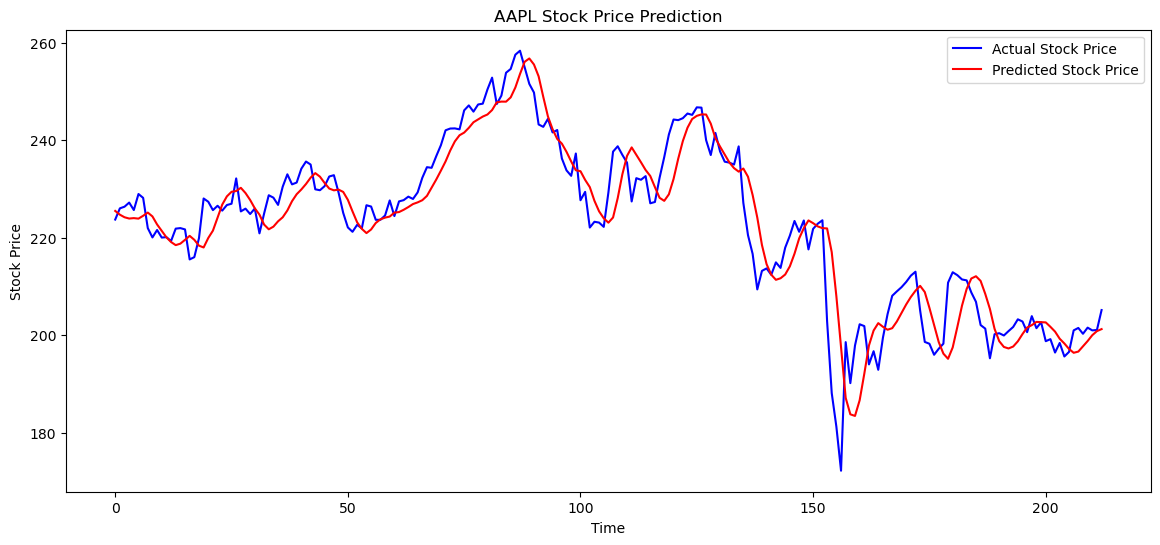

In [17]:
plt.figure(figsize=(14,6))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(y_pred_actual, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()